# Plan
* tokenization of code
* sliding window to create features and labels
* use sequence of tokens as X, next token as Y
* train model (RF/DT in the beginning))
* apply model to find interesting places in repository

In [1]:
from collections import defaultdict
import os
import glob

import bblfsh
import numpy as np
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, namedtuple, defaultdict, Sequence


## Prepare data

In [2]:
!git clone --depth=1 --single-branch https://github.com/freeCodeCamp/freeCodeCamp

Cloning into 'freeCodeCamp'...
remote: Counting objects: 589, done.
remote: Compressing objects: 100% (528/528), done.
remote: Total 589 (delta 36), reused 287 (delta 13), pack-reused 0
Receiving objects: 100% (589/589), 1.60 MiB | 1.05 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [3]:
project = "freeCodeCamp/**/*.js"

In [4]:
# collect filenames with full path
files = glob.glob(project, recursive=True)

# extract UASTs
client = bblfsh.BblfshClient("0.0.0.0:9432")
uasts = []
final_files = []  # only files where UAST can be extracted
for file in tqdm(files):
    res = client.parse(file)
    if res.status == 0:
        uasts.append(res.uast)
        final_files.append(file)

# read contents of files
contents = []
for file in tqdm(final_files):
    with open(file, "r") as f:
        contents.append(f.read())

100%|██████████| 208/208 [00:00<00:00, 36452.40it/s]


## Visualization of code


In [6]:
from common import transform_content, extract_nodes

n = 50

print(transform_content(contents[n], uasts[n]))

import { _____ } from _________;

export { _______ } from _______________;

export const ______ = {
  [_____.______________]: ____________
};



# Feature extraction

## On input
* content
* uast
## Process
* ordered_nodes -> list of nodes
* select gapes between nodes
* split gapes into whitespaces/newlines/etc and keywords/operators
* create one list with all elements - nodes, whitespaces/newlines/etc, keywords/operators

In [9]:
from lookout.style.format import reserved

res = extract_nodes(contents[n], uasts[n], reserved.javascript.TOKENS)
new_res = []
for i in res:
    if isinstance(i.node, str):
        new_res.append(i.node)
    else:
        new_res.append(i.node.token)
print("-=+" * 20)
print("".join(new_res))
print("-=+" * 20)
print(contents[n])

-=+-=+-=+-=+-=+-=+-=+-=+-=+-=+-=+-=+-=+-=+-=+-=+-=+-=+-=+-=+
import { types } from ./redux;

export { default } from ./Profile.jsx;

export const routes = {
  [types.onRouteProfile]: /:username
};

-=+-=+-=+-=+-=+-=+-=+-=+-=+-=+-=+-=+-=+-=+-=+-=+-=+-=+-=+-=+
import { types } from './redux';

export { default } from './Profile.jsx';

export const routes = {
  [types.onRouteProfile]: '/:username'
};



# Train the model

In [20]:
from importlib import reload
import common
reload(common)


Node, prepare_nodes, transform_content = common.WrappedNode, common.prepare_nodes, common.transform_content
extract_nodes = common.extract_nodes
collect_unique_features = common.collect_unique_features
extract_features = common.extract_features

In [21]:
params = {"min_samples_split": 40, "min_samples_leaf": 40,
          "criterion": "gini"}


def train_pipeline(final_files, contents, uasts, dt_params=params, use_features_after=True, seq_len=5, depth=5,
                   use_parents=True):
    features, labels, metadata = extract_features(
        final_files, contents, uasts, seq_len=seq_len, use_features_after=use_features_after,
        depth=depth, use_parents=use_parents, reserved_tokens=reserved.javascript.TOKENS)
    features = np.array(features)
    labels = np.array(labels)
    print("Features shape:", features.shape)
    X_tr, X_val, y_tr, y_val, meta_tr, meta_val = train_test_split(features, labels, metadata, random_state=1989)
    
    clf = tree.DecisionTreeClassifier(**dt_params)

    clf = clf.fit(X_tr, y_tr)

    print("train:", accuracy_score(clf.predict(X_tr), y_tr))
    print("val:", accuracy_score(clf.predict(X_val), y_val))
    
    data = {"X_tr": X_tr, "X_val": X_val, "y_tr": y_tr, "y_val": y_val, "meta_tr": meta_tr,
            "meta_val": meta_val, "features": features, "labels": labels, 
            "metadata": metadata}
    
    l_cnter = defaultdict(int)
    for l in labels:
        l_cnter[l] += 1
    print(l_cnter)
    return clf, data

In [22]:
_ = train_pipeline(final_files, contents, uasts, dt_params=params, use_features_after=True, seq_len=5, depth=5)

163it [00:01, 84.67it/s] 


AssertionError: token_to_seq: `short]` != `shortId]`

In [36]:
_ = train_pipeline(final_files, contents, uasts, dt_params=params, use_features_after=False, seq_len=5, depth=5)

187it [00:05, 31.39it/s]
187it [00:19,  9.74it/s]


Features shape: (268367, 40)
train: 0.9454378338094647
val: 0.9406039468192929


In [37]:
_ = train_pipeline(final_files, contents, uasts, dt_params=params, use_features_after=True, use_parents=False,
                   seq_len=5, depth=5)

187it [00:05, 31.51it/s] 
187it [00:12, 14.41it/s]


Features shape: (268367, 20)
train: 0.9834902496584276
val: 0.9823078757526977


In [38]:
_ = train_pipeline(final_files, contents, uasts, dt_params=params, use_features_after=True, use_parents=True,
                   seq_len=1, depth=1)

187it [00:05, 32.33it/s]
187it [00:10, 17.79it/s]


Features shape: (269859, 6)
train: 0.9650829570046543
val: 0.9630771511153932


In [78]:
clf, data = train_pipeline(final_files, contents, uasts, dt_params=params, use_features_after=True, 
                           use_parents=True, seq_len=2, depth=2)

187it [00:05, 33.80it/s] 
187it [00:12, 14.61it/s]


Features shape: (269485, 16)
train: 0.98478079094368
val: 0.983346197233272
defaultdict(<class 'int'>, {0: 175905, 1: 75575, 2: 9920, 3: 4175, 4: 3910})


In [48]:
_ = train_pipeline(final_files, contents, uasts, dt_params=params, use_features_after=True, 
                           use_parents=False, seq_len=2, depth=2)

187it [00:05, 33.73it/s] 
187it [00:10, 18.29it/s]


Features shape: (269485, 8)
train: 0.9844245545808533
val: 0.9830196520809832
defaultdict(<class 'int'>, {0: 175905, 1: 75575, 2: 9920, 3: 4175, 4: 3910})


### Tl;Dr - couple of tokens before & after prediction spot + parent info gives the best performance

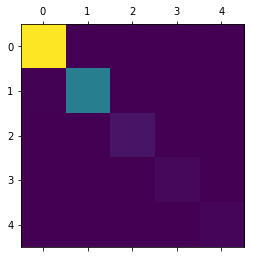

In [44]:
from sklearn.metrics import confusion_matrix
%matplotlib inline


conf_mat = confusion_matrix(data["y_val"], clf.predict(data["X_val"]))

matshow(conf_mat)

In [79]:
from sklearn.metrics import classification_report

target_names = ["nope", "whitespace", "newline", "newline_incr", "newline_decr"]
print(classification_report(data["y_val"], clf.predict(data["X_val"]), target_names=target_names))

              precision    recall  f1-score   support

        nope       0.99      0.99      0.99     43877
  whitespace       0.98      0.98      0.98     19039
     newline       0.93      0.94      0.94      2402
newline_incr       0.91      0.83      0.87      1027
newline_decr       0.87      0.80      0.83      1027

 avg / total       0.98      0.98      0.98     67372



In [80]:
predictions_proba = clf.predict_proba(data["X_val"])
max_pred = np.argmax(predictions_proba, axis=-1)

In [81]:
predictions = clf.predict(data["X_val"])

In [83]:
max_predictions = predictions_proba[np.arange(max_pred.shape[0]), max_pred]
print(max_predictions.shape)
sorted_ind = np.argsort(max_predictions)

(67372,)


In [84]:
WHITE = "\033[0m"
RED = "\033[31m"
GREEN = "\033[32m"
ORANGE = "\033[33m"
BLUE = "\033[34m"
PURPLE = "\033[35m"


def visualize_content(meta, context_chars=100):
    file, start, end, l_start, l_end = meta
    with open(file, "r") as f:
        content = f.read()
    
    # surrounding context
    print(content[max(0, start - context_chars):start], end="")
    # context before label
    cprint(content[start:l_start], "red", "on_white", end="")
    # label
    cprint(content[l_start:l_end], "blue", "on_yellow", end="")
    # context after label
    cprint(content[l_end:end], "red", "on_white", end="")
    # surrounding context
    print(content[end:min(len(content), end + context_chars)])
    

In [73]:
from termcolor import colored, cprint
cprint("asdas", "red", "on_green")

asdas


In [85]:
n = sorted_ind[0]
data["meta_val"][n], target_names[data["y_val"][n]], target_names[predictions[n]]

(('/home/egor/workspace/tmp/freeCodeCamp/common/models/user.js',
  21932,
  21946,
  21934,
  21941),
 'newline',
 'whitespace')

In [86]:
visualize_content(data["meta_val"][n], context_chars=200)

dateData.$push.progressTimestamps = {
            $each: points.map(() => Date.now())
          };
        }
        return this.update$(updateData);
      })
      .doOnNext(() => this.manualReload() )
      .map(() => dedent`
        Your projects have been updated.
      `);
  };

  User.prototype.updateMyProfileUI = function updateMyProfileUI(profileUI) {
    const oldUI = { ...this.profileUI };
    const u


In [87]:
n = sorted_ind[1]
print(data["meta_val"][n], "GT", target_names[data["y_val"][n]], ", pred", target_names[predictions[n]])

('/home/egor/workspace/tmp/freeCodeCamp/server/boot/challenge.js', 7181, 7197, 7189, 7194) GT newline_decr , pred whitespace


In [88]:
visualize_content(data["meta_val"][n], context_chars=200)

ate.now();

    if (
      !completedChallenge.solution ||
      // only basejumps require github links
      (
        completedChallenge.challengeType === 4 &&
        !completedChallenge.githubLink
      )
    ) {
      req.flash(
        'danger',
        'You haven\'t supplied the necessary URLs for us to inspect your work.'
      );
      return res.sendStatus(403);
    }


    return user.getCompletedChall


In [89]:
n = sorted_ind[2]
print(data["meta_val"][n], "GT", target_names[data["y_val"][n]], ", pred", target_names[predictions[n]])

('/home/egor/workspace/tmp/freeCodeCamp/server/boot/certificate.js', 5495, 5507, 5501, 5504) GT newline_decr , pred whitespace


In [90]:
visualize_content(data["meta_val"][n], context_chars=200)

ms.username}/legacy-data-visualization`
    )
  );

  router.get(
    '/:username/back-end-certification',
    (req, res) => res.redirect(
      `/certification/${req.params.username}/legacy-back-end`
    )
  );

  router.get(
    '/:username/full-stack-certification',
    (req, res) => res.redirect(
      `/certification/${req.params.username}/legacy-full-stack`
    )
  );

  router.post(
    '/certificate/v


In [91]:
n = sorted_ind[100]
print(data["meta_val"][n], "GT", target_names[data["y_val"][n]], ", pred", target_names[predictions[n]])

('/home/egor/workspace/tmp/freeCodeCamp/common/app/Flash/redux/index.js', 1094, 1121, 1103, 1114) GT nope , pred newline


In [92]:
visualize_content(data["meta_val"][n], context_chars=200)

      [types.clickOnClose]: _.tail,
      [types.fetchMessages.complete]: (state, { payload }) => [
        ...state,
        ...utils.expressToStack(payload)
      ]
    }),
    defaultState,
  ),
  function metaReducer(state = defaultState, action) {
    if (utils.isFlashAction(action)) {
      const { payload } = utils.getFlashAction(action);
      return [
        ...state,
        ...payload
      ];
    }
    return s
